## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_horizontal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\coco\\indoor\\wavelet\\horizontal\\red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


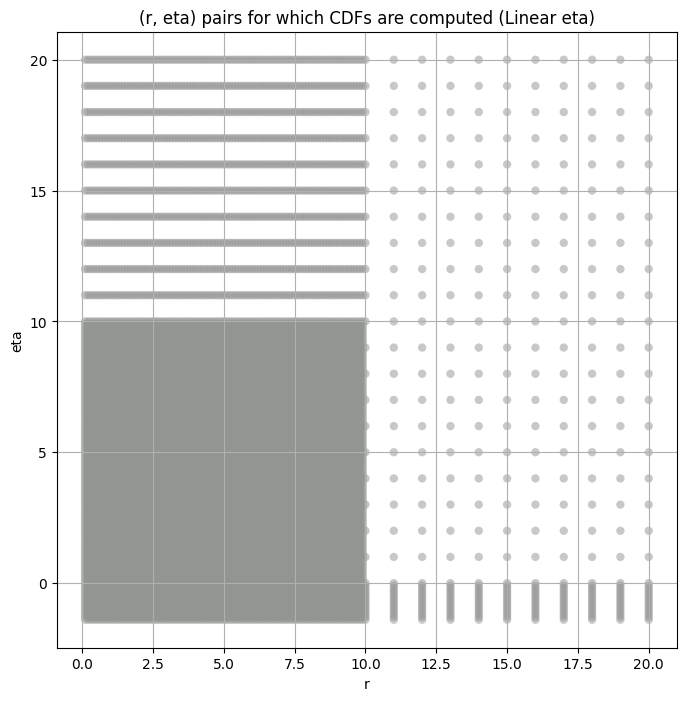

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6587.218800  5829.085400  7390.837000   1.388779    0.753041   
3      1562.001600  1443.514600  1685.957800   3.834879    3.130261   
4       337.561950   313.361850   362.564180   5.918980    5.145904   
5        63.356410    58.123432    68.839920   8.944126    7.824841   
6        11.491563    10.353099    12.688133  13.758188   11.807414   
7         2.062334     1.823033     2.322947  19.980927   16.740900   
8         0.403471     0.351124     0.461097  25.597855   20.274683   
9         0.117287     0.103159     0.132794  22.309376   16.614643   

       kurt_upper  total_samples  
layer                             
2        2.140820           1604  
3        4.593748           6416  
4        6.765697          25664  
5       10.135998         102656  
6       15.933593         410624  
7       23.600847        1642496  
8       31.850876        6569984  
9       28.714006       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      6587.218800    6587.218750     4993.675781     4105.312012   
3      1562.001600    1562.001587     1343.829102     1212.604614   
4       337.561950     337.561951      317.300537      302.767670   
5        63.356410      63.356411       61.882942       60.648178   
6        11.491563      11.491563       11.113305       10.813106   
7         2.062334       2.062334        1.971107        1.901079   
8         0.403471       0.403471        0.380305        0.363709   
9         0.117287       0.117287        0.110480        0.105693   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         3457.780518      2979.949463      2259.254883      1698.389282   
3         1112.086670      1026.751709       888.979248       787.619263   
4          290.660919       280.207733       261.966064       246.259735   
5           59.538719        58.525620        56.695557        55.053551   
6           10.548075        10.308170         9.886875         9.519312   
7            1.841012         1.787865         1.695215         1.614865   
8            0.349814         0.337736         0.317227         0.300010   
9            0.101778         0.098426         0.092861         0.088330   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1294.263428       964.068298       707.189697       232.200592  
3           704.328430       632.926514       571.253601       429.667938  
4           232.555481       220.475296       209.696579       182.729034  
5            53.551979        52.171543        50.883625        47.507645  
6             9.188291         8.886395         8.608646         7.887316  
7             1.544002         1.480273         1.422491         1.275188  
8             0.285118         0.272002         0.260273         0.231201  
9             0.084505         0.081196         0.078285         0.071225

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.08602094545292832 6587.2188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.08736686065225674 4993.676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.09077377607548842 4105.312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.10142399723078432 3457.7805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.11818355491626031 2979.9495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.1473835269054672 2259.255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.17472829713177818 1698.3893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.19920290415524033 1294.2634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.22623425120452478 964.0683


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.25601565277722993 707.1897


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.3394324147257146 232.20059
Number of samples: 1604, Without approximation : 1604


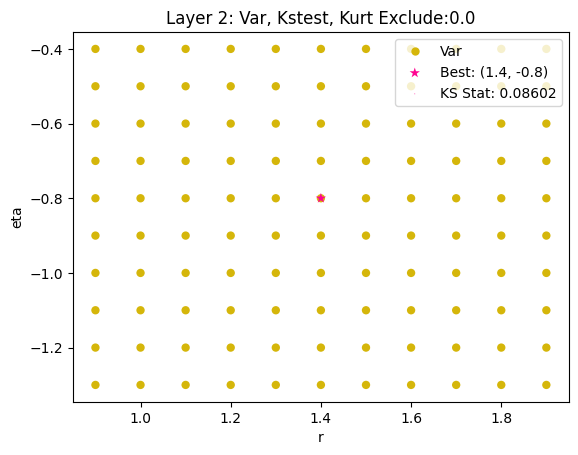

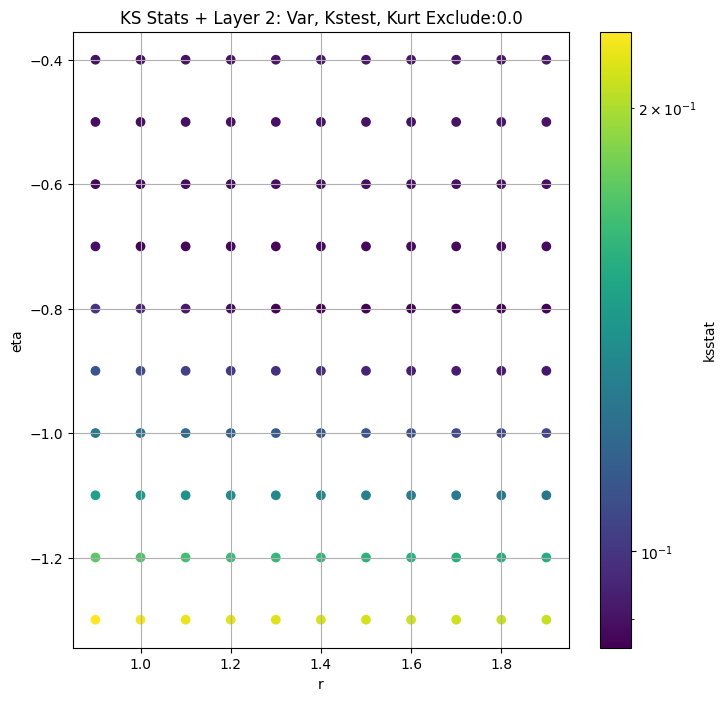

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.06858387480045686 1562.0016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.06861241533076207 1343.8291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.06864326046141106 1212.6046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.06865875885695727 1112.0867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.0687518519488331 1026.7517


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.07376913274493041 888.97925


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.07406558527916368 787.61926


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.07865526343189128 704.3284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.08131565531729235 632.9265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.08624721075395414 571.2536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.10542152978285302 429.66794
Number of samples: 6416, Without approximation : 6416


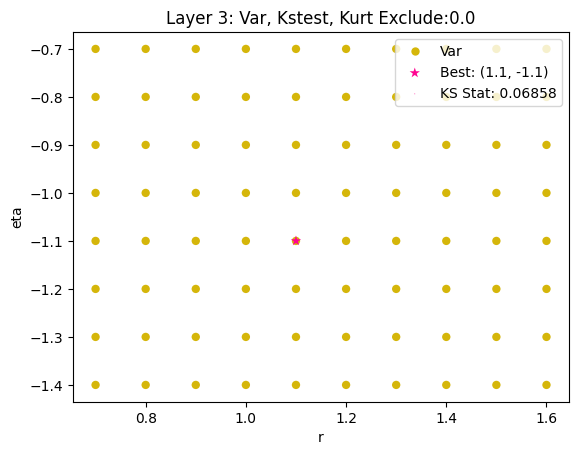

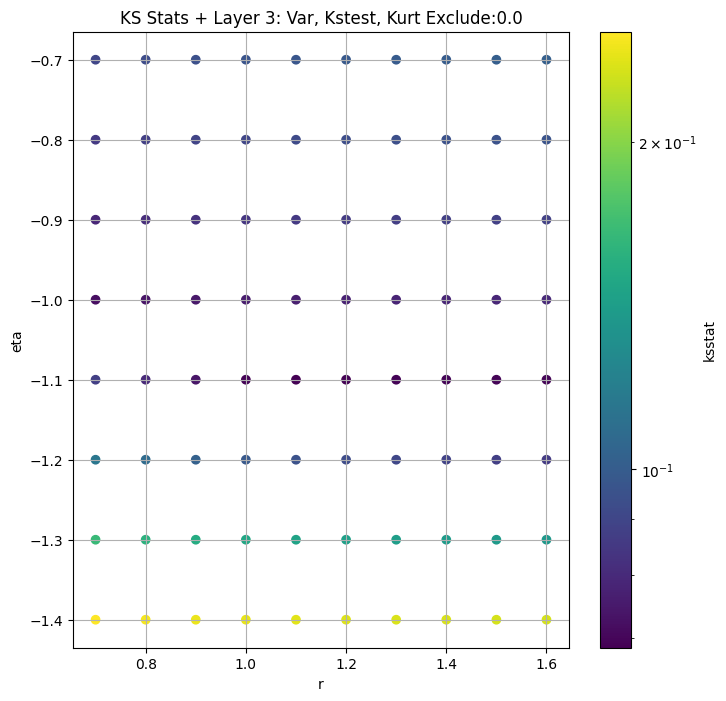

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.06748753117206974 337.56195


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.06748753117206974 317.30054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.06748753117206974 302.76767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.06748753117206974 290.66092


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.06748753117206974 280.20773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.06748753117206974 261.96606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.06748753117206974 246.25974


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.06748753117206974 232.55548


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.06874376725910969 220.4753


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.06929777847659252 209.69658


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.06897158836220968 182.72903
Number of samples: 25664, Without approximation : 25664


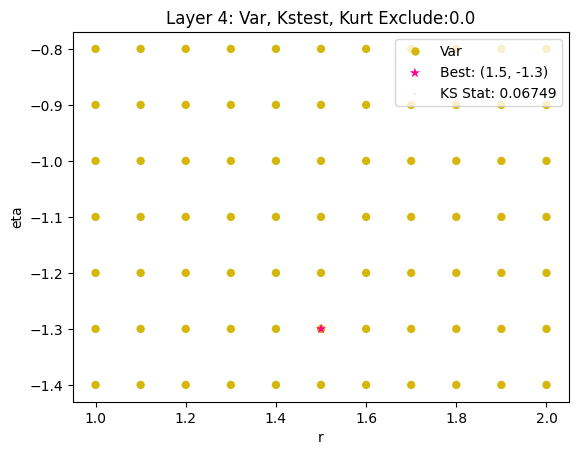

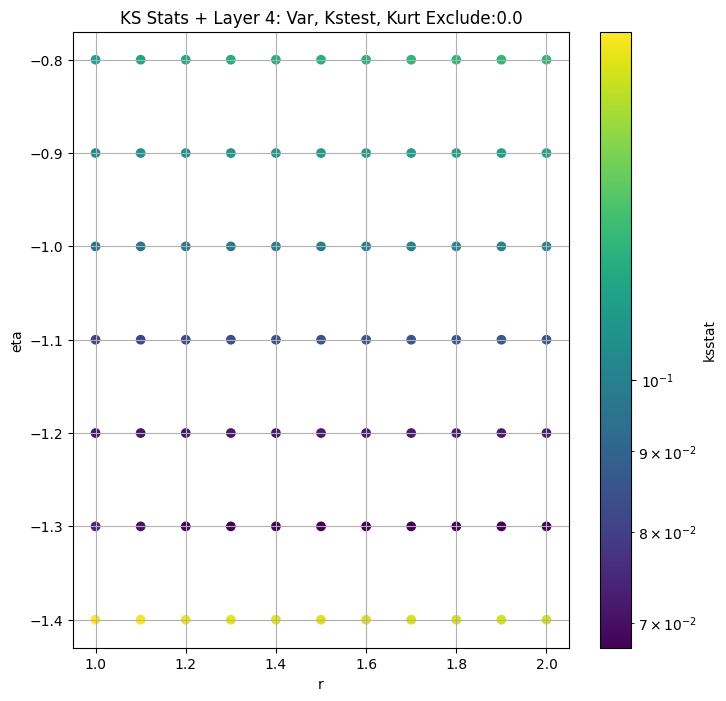

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.09548999999999985 63.35641


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.09548999999999985 61.882942


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.09548999999999985 60.64818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.09548999999999985 59.53872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.09548999999999985 58.52562


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.09548999999999985 56.695557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.09548999999999985 55.05355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.09548999999999985 53.55198


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.09548999999999985 52.171543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.09548999999999985 50.883625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.09548999999999985 47.507645
Number of samples: 100000, Without approximation : 102656


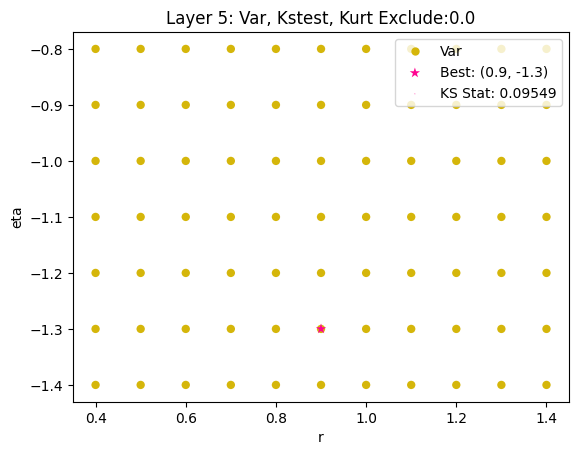

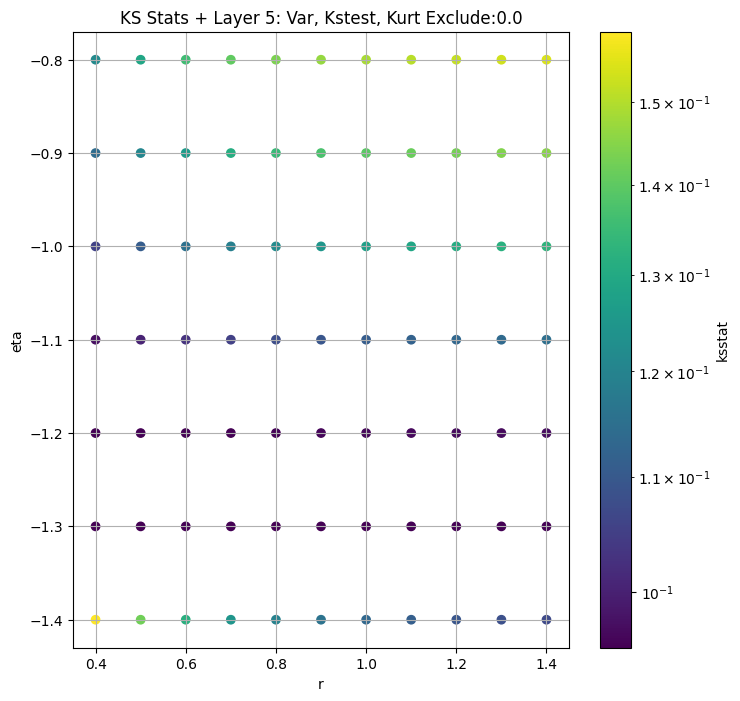

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.13386999999999977 11.491563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.13386999999999977 11.113305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.13386999999999977 10.813106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.13386999999999977 10.548075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.13386999999999977 10.30817


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.13386999999999977 9.886875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.13386999999999977 9.519312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.13386999999999977 9.188291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.13386999999999977 8.886395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.13386999999999977 8.608646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.13386999999999977 7.8873158
Number of samples: 100000, Without approximation : 410624


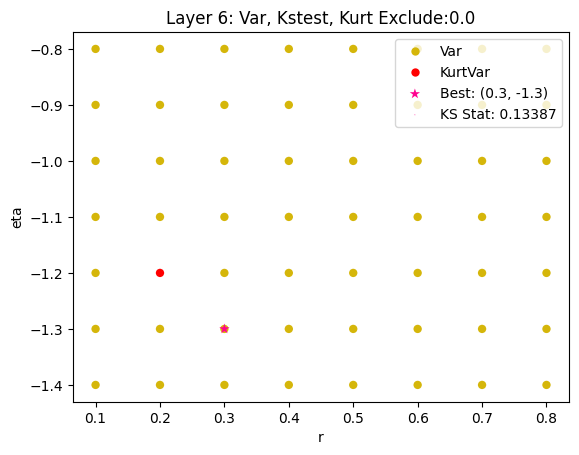

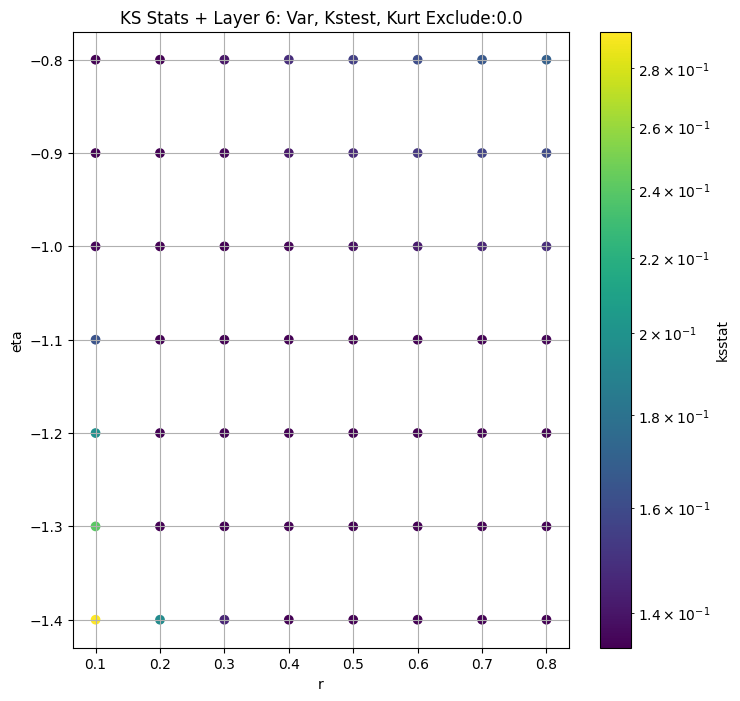

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.17333999999999977 2.062334


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.17333999999999977 1.9711065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.17333999999999977 1.9010786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.17333999999999977 1.8410121


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.17333999999999977 1.7878653


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.17333999999999977 1.695215


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.17333999999999977 1.6148646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.17333999999999977 1.5440016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.17333999999999977 1.4802729


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.17333999999999977 1.4224906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.17333999999999977 1.2751881
Number of samples: 100000, Without approximation : 1642496


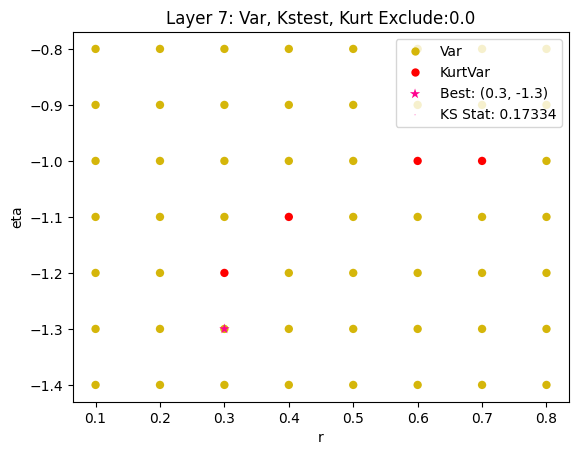

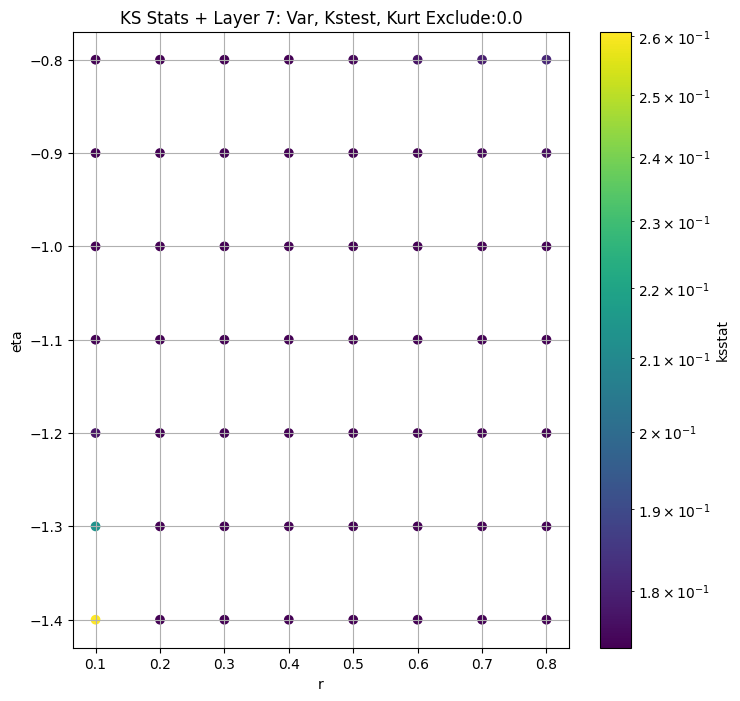

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.20764999999999978 0.4034712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.20764999999999978 0.38030514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.20764999999999978 0.36370906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.20764999999999978 0.34981447


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.20764999999999978 0.3377365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.20764999999999978 0.31722683


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.20764999999999978 0.30001035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.20764999999999978 0.28511828


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.20764999999999978 0.27200246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.20764999999999978 0.26027292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.20764999999999978 0.23120128
Number of samples: 100000, Without approximation : 6569984


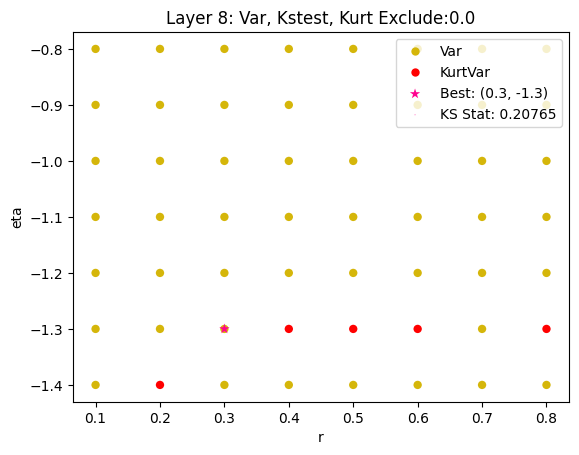

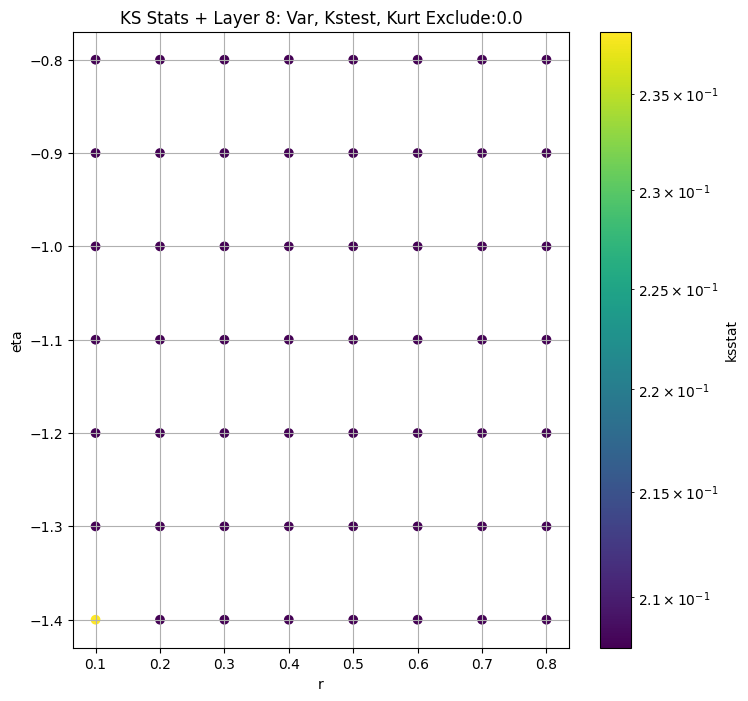

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.24049999999999977 0.1172869


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.24049999999999977 0.11048025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.24049999999999977 0.10569261


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.24049999999999977 0.10177841


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.24049999999999977 0.098425955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.24049999999999977 0.092860796


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.24049999999999977 0.08832984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.24049999999999977 0.084504895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.24049999999999977 0.081196345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.24049999999999977 0.07828461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.24049999999999977 0.07122453
Number of samples: 100000, Without approximation : 26279936


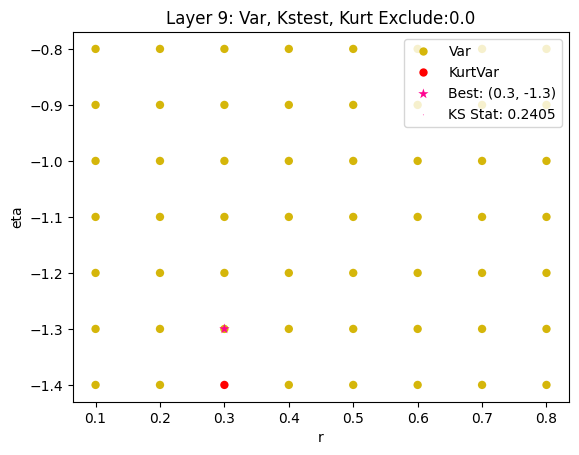

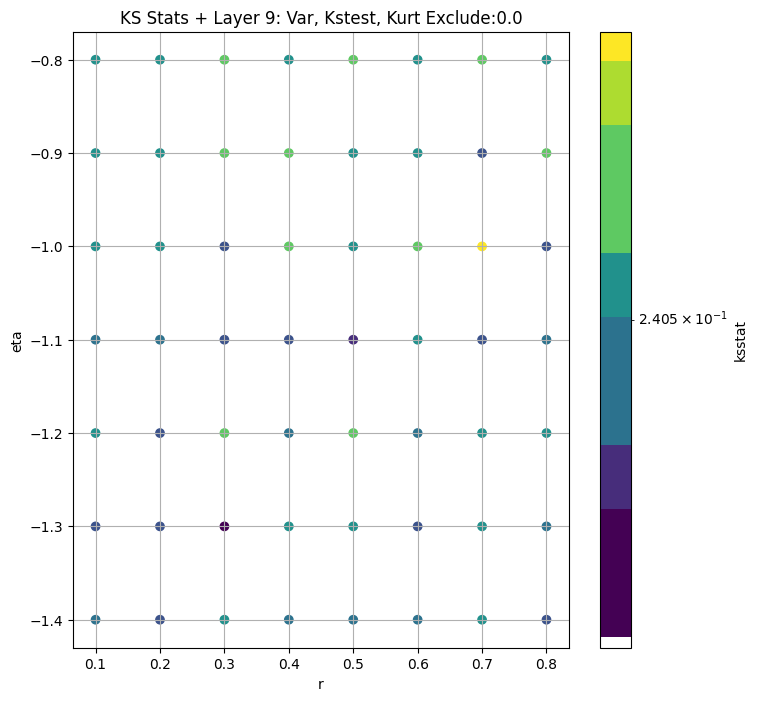

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6587.218800  5829.085400  7390.837000   1.388779    0.753041   
3      1562.001600  1443.514600  1685.957800   3.834879    3.130261   
4       337.561950   313.361850   362.564180   5.918980    5.145904   
5        63.356410    58.123432    68.839920   8.944126    7.824841   
6        11.491563    10.353099    12.688133  13.758188   11.807414   
7         2.062334     1.823033     2.322947  19.980927   16.740900   
8         0.403471     0.351124     0.461097  25.597855   20.274683   
9         0.117287     0.103159     0.132794  22.309376   16.614643   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.140820           1604             0.086021        1.4         -0.8   
3        4.593748           6416             0.068584        1.1         -1.1   
4        6.765697          25664             0.067488        1.5         -1.3   
5       10.135998         102656             0.095490        0.9         -1.3   
6       15.933593         410624             0.133870        0.3         -1.3   
7       23.600847        1642496             0.173340        0.3         -1.3   
8       31.850876        6569984             0.207650        0.3         -1.3   
9       28.714006       26279936             0.240500        0.3         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       12767.090191                     0.0         6587.218800   
3        4237.649654                     0.0         1562.001600   
4        2041.376881                     0.0          337.561950   
5         291.359588                     0.0           63.356410   
6           2.593489                     0.0           11.491563   
7           0.465441                     0.0            2.062334   
8           0.091058                     0.0            0.403471   
9           0.026470                     0.0            0.117287   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.13101189799188862, var: 2979.949462890625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.11696145064013508, var: 3457.780517578125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.1004467334320912, var: 4105.31201171875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.08806169725800561, var: 4993.67578125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.08589949689884158, var: 6587.21875
Number of samples: 1604, Without approximation : 1604


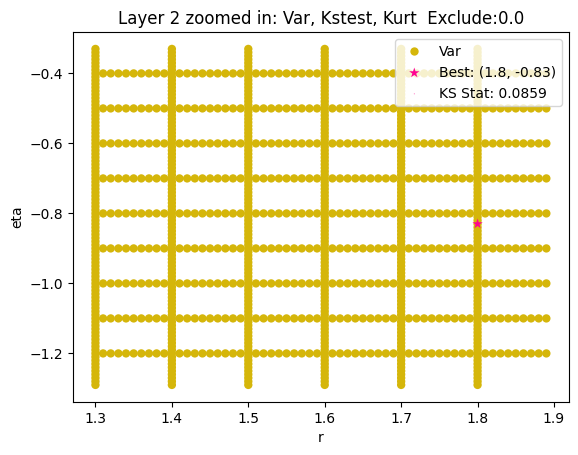

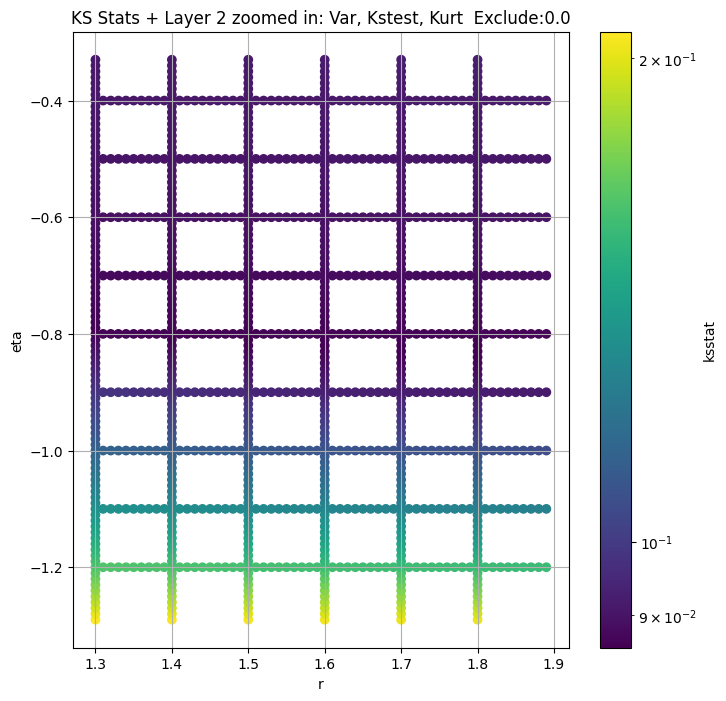

Layer 3


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.07252840515859027, var: 1026.751708984375


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.0711073839443832, var: 1112.086669921875


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.0696306782866169, var: 1212.6046142578125


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.0682896402518679, var: 1343.8291015625


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.06724368394795821, var: 1562.0015869140625
Number of samples: 6416, Without approximation : 6416


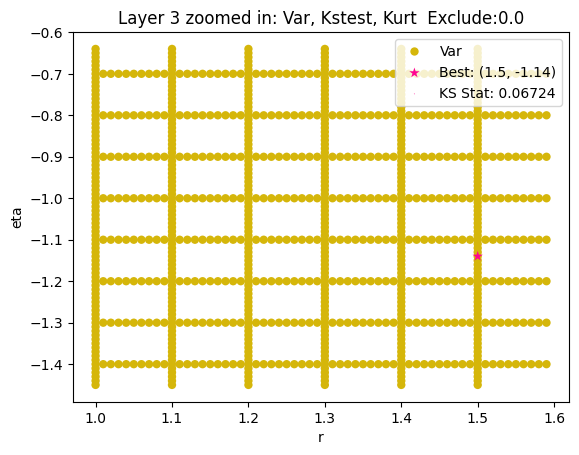

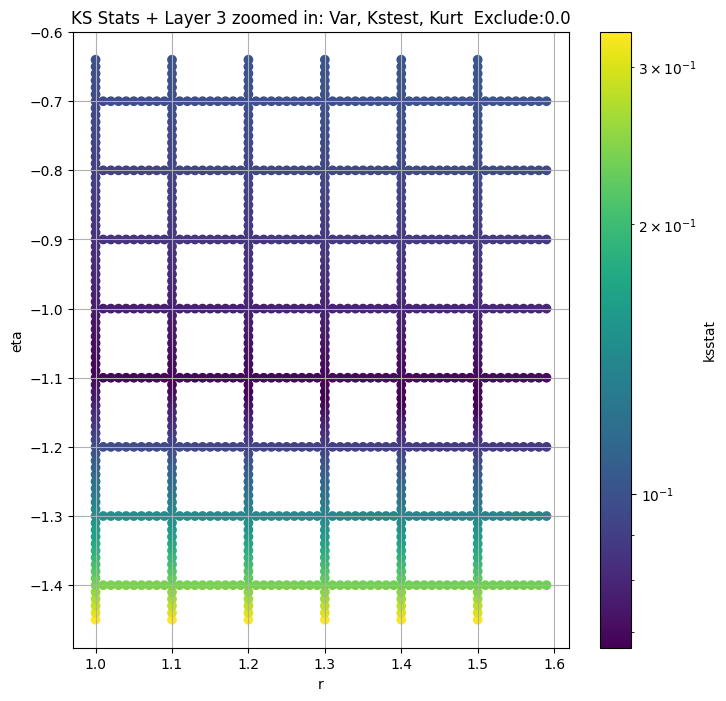

Layer 4


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.06748753117206968, var: 280.2077331542969


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.06748753117206968, var: 290.6609191894531


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.06748753117206968, var: 302.7676696777344


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.06748753117206968, var: 317.300537109375


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.06748753117206968, var: 337.56195068359375
Number of samples: 25664, Without approximation : 25664


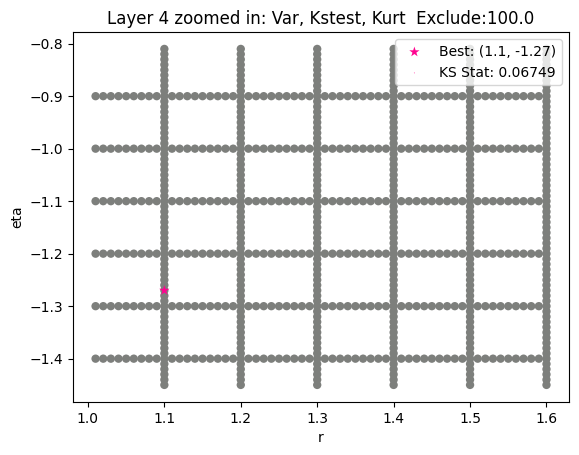

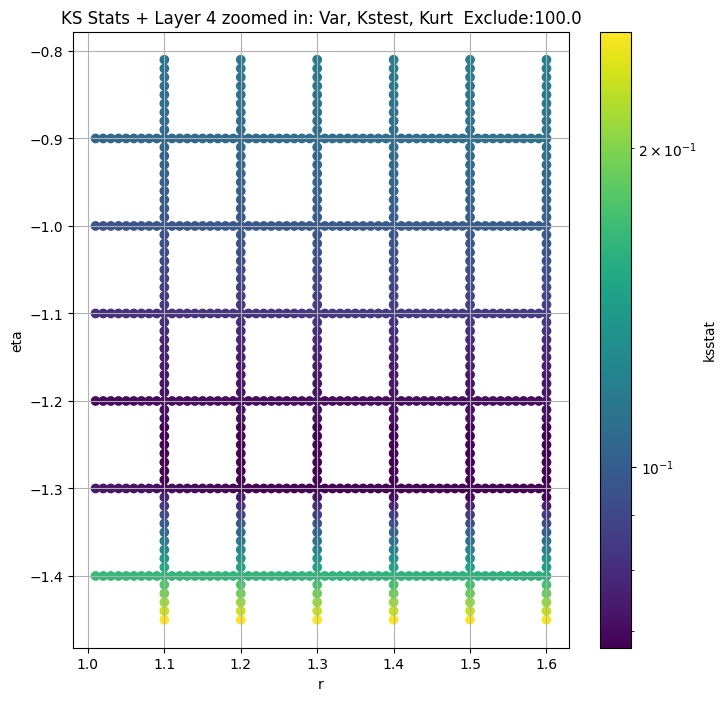

Layer 5


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0954899999999998, var: 58.52561950683594


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.0954899999999998, var: 59.538719177246094


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0954899999999998, var: 60.64817810058594


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.0954899999999998, var: 61.88294219970703


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0954899999999998, var: 63.35641098022461
Number of samples: 100000, Without approximation : 102656


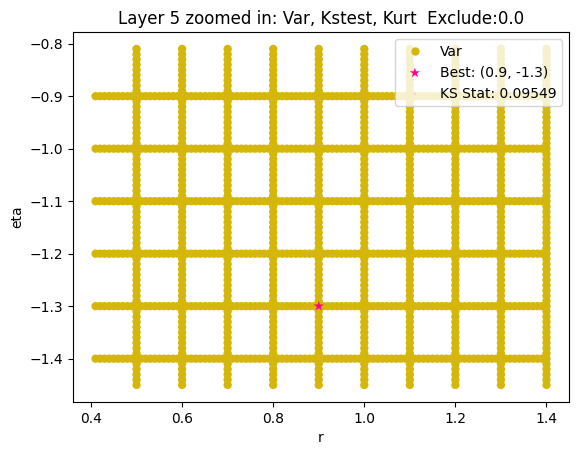

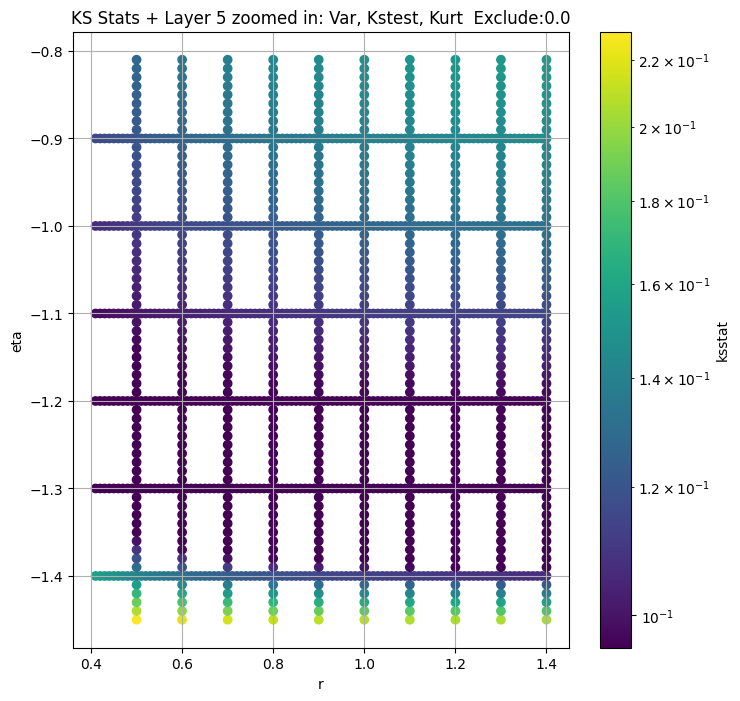

Layer 6


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.13386999999999977, var: 10.308170318603516


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.13386999999999977, var: 10.548074722290039


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.13386999999999977, var: 10.813105583190918


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.13386999999999977, var: 11.11330509185791


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.13386999999999977, var: 11.491562843322754
Number of samples: 100000, Without approximation : 410624


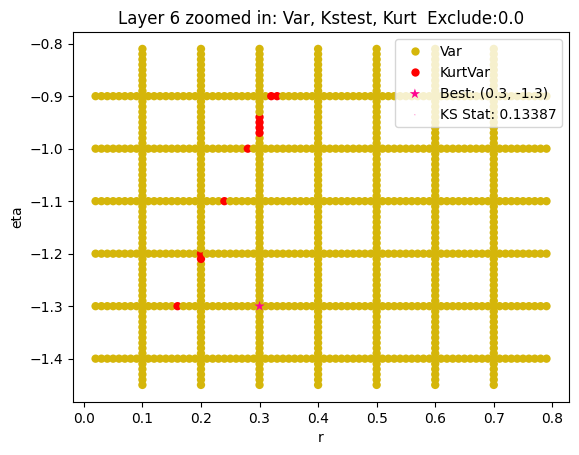

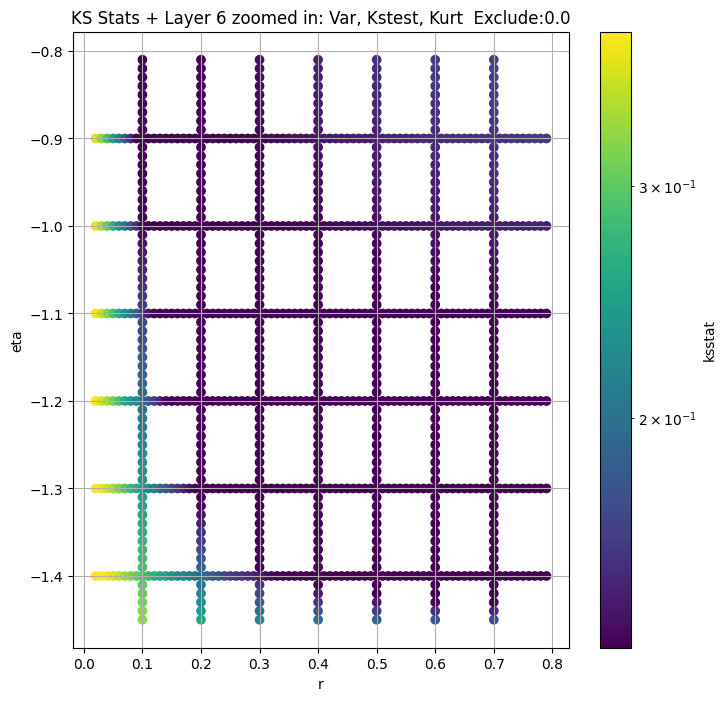

Layer 7


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.17333999999999977, var: 1.7878652811050415


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.17333999999999977, var: 1.8410121202468872


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.17333999999999977, var: 1.9010785818099976


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.17333999999999977, var: 1.9711065292358398


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.17333999999999977, var: 2.0623340606689453
Number of samples: 100000, Without approximation : 1642496


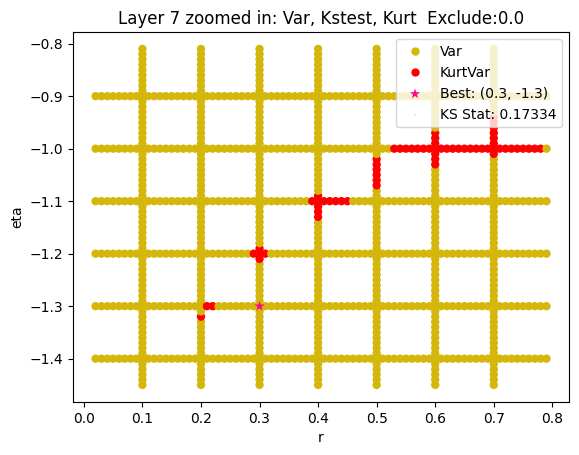

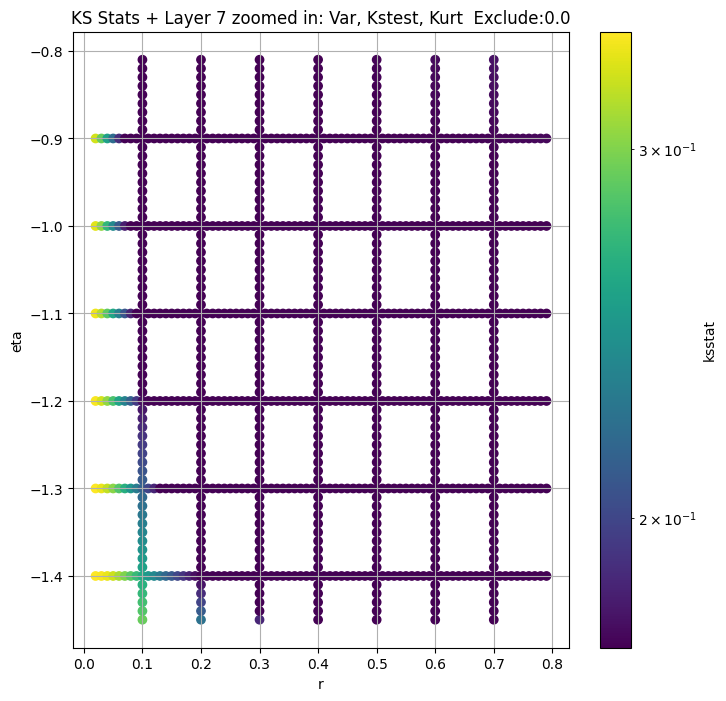

Layer 8


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.20764999999999978, var: 0.33773648738861084


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.20764999999999978, var: 0.3498144745826721


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.20764999999999978, var: 0.36370906233787537


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.20764999999999978, var: 0.38030514121055603


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.20764999999999978, var: 0.4034712016582489
Number of samples: 100000, Without approximation : 6569984


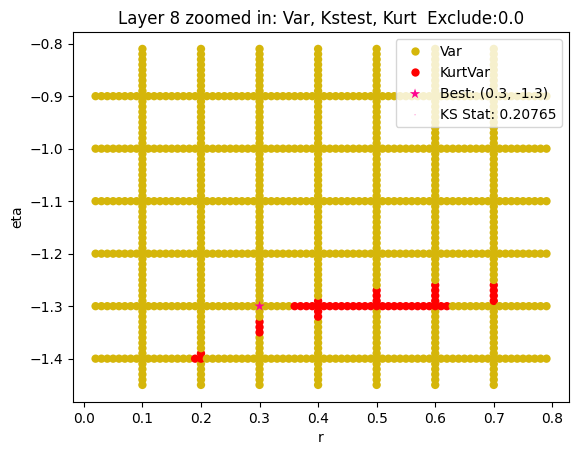

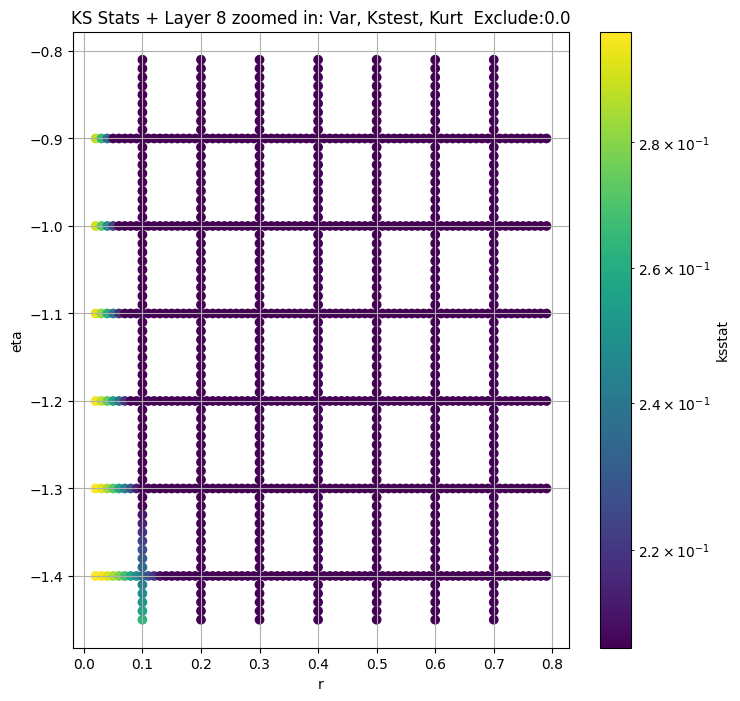

Layer 9


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.24049999999999977, var: 0.098425954580307


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.24049999999999977, var: 0.10177841037511826


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.24049999999999977, var: 0.10569261014461517


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.24049999999999977, var: 0.11048024892807007


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.24049999999999977, var: 0.11728689819574356
Number of samples: 100000, Without approximation : 26279936


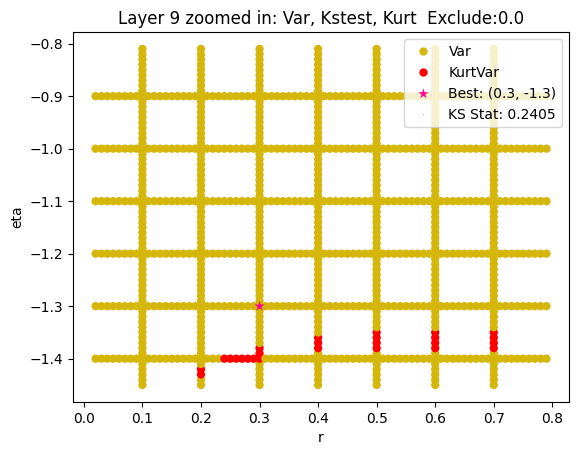

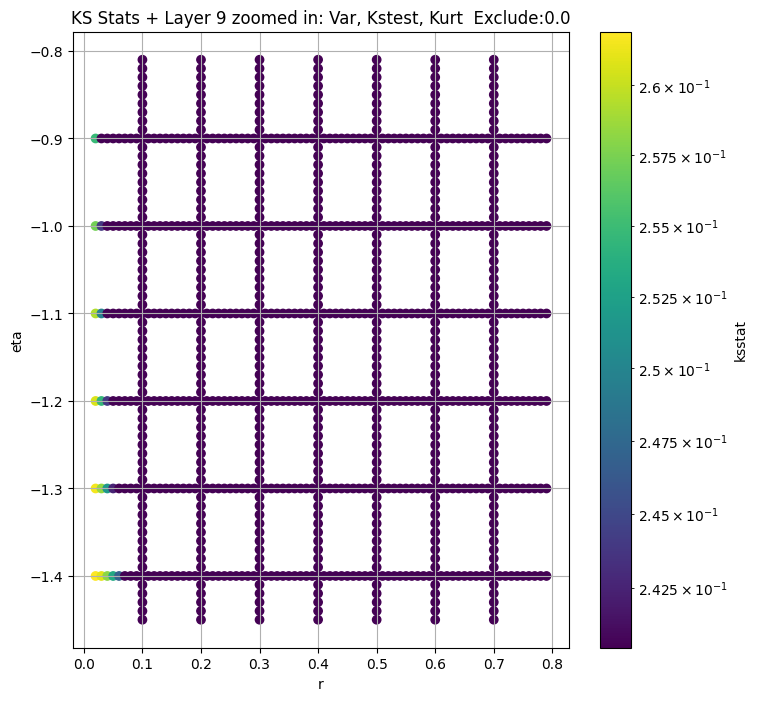

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6587.218800  5829.085400  7390.837000   1.388779    0.753041   
3      1562.001600  1443.514600  1685.957800   3.834879    3.130261   
4       337.561950   313.361850   362.564180   5.918980    5.145904   
5        63.356410    58.123432    68.839920   8.944126    7.824841   
6        11.491563    10.353099    12.688133  13.758188   11.807414   
7         2.062334     1.823033     2.322947  19.980927   16.740900   
8         0.403471     0.351124     0.461097  25.597855   20.274683   
9         0.117287     0.103159     0.132794  22.309376   16.614643   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.140820           1604             0.086021        1.4         -0.8   
3        4.593748           6416             0.068584        1.1         -1.1   
4        6.765697          25664             0.067488        1.5         -1.3   
5       10.135998         102656             0.095490        0.9         -1.3   
6       15.933593         410624             0.133870        0.3         -1.3   
7       23.600847        1642496             0.173340        0.3         -1.3   
8       31.850876        6569984             0.207650        0.3         -1.3   
9       28.714006       26279936             0.240500        0.3         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       12767.090191                     0.0         6587.218750   
3        4237.649654                     0.0         1562.001587   
4        2041.376881                     0.0          280.207733   
5         291.359588                     0.0           63.356410   
6           2.593489                     0.0           11.491563   
7           0.465441                     0.0            2.062334   
8           0.091058                     0.0            0.403471   
9           0.026470                     0.0            0.117287   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.085899     1.8     -0.83   
3                     0.016929          0.067244     1.5     -1.14   
4                     0.008471          0.067488     1.1     -1.27   
5                     0.004237          0.095490     0.9     -1.30   
6                     0.002119          0.133870     0.3     -1.30   
7                     0.001060          0.173340     0.3     -1.30   
8                     0.000530          0.207650     0.3     -1.30   
9                     0.000265          0.240500     0.3     -1.30   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      15025.522582                  0.0          252  
3       5560.907151                  0.0          401  
4       1299.727434                100.0          401  
5        291.359588                  0.0          200  
6          2.593489                  0.0          100  
7          0.465441                  0.0           61  
8          0.091058                  0.0           40  
9          0.026470                  0.0           30

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

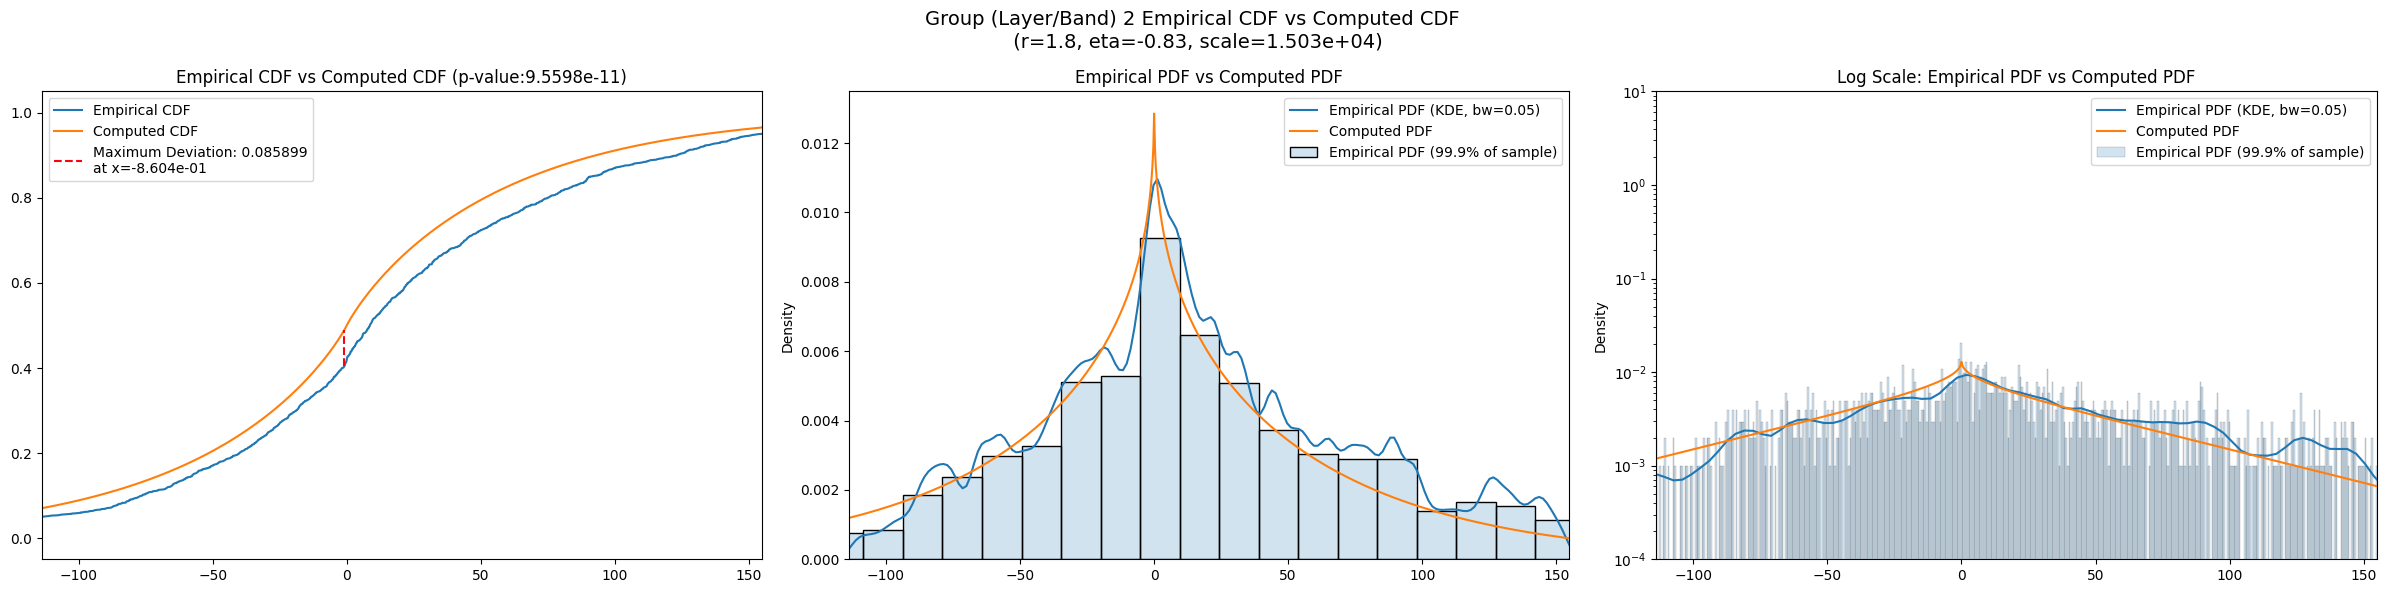

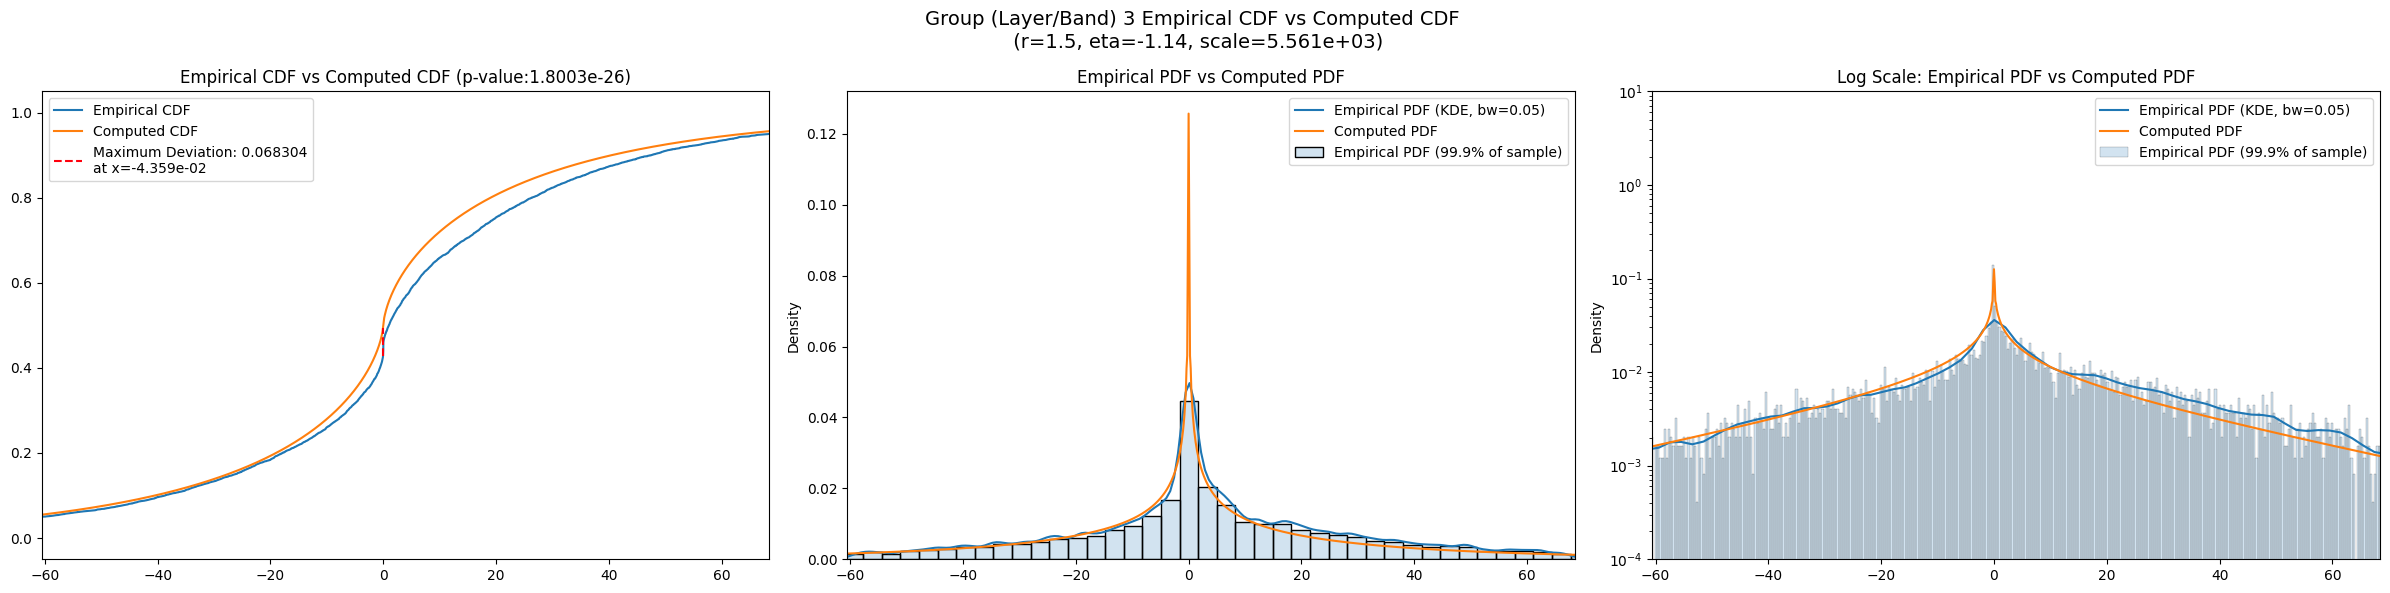

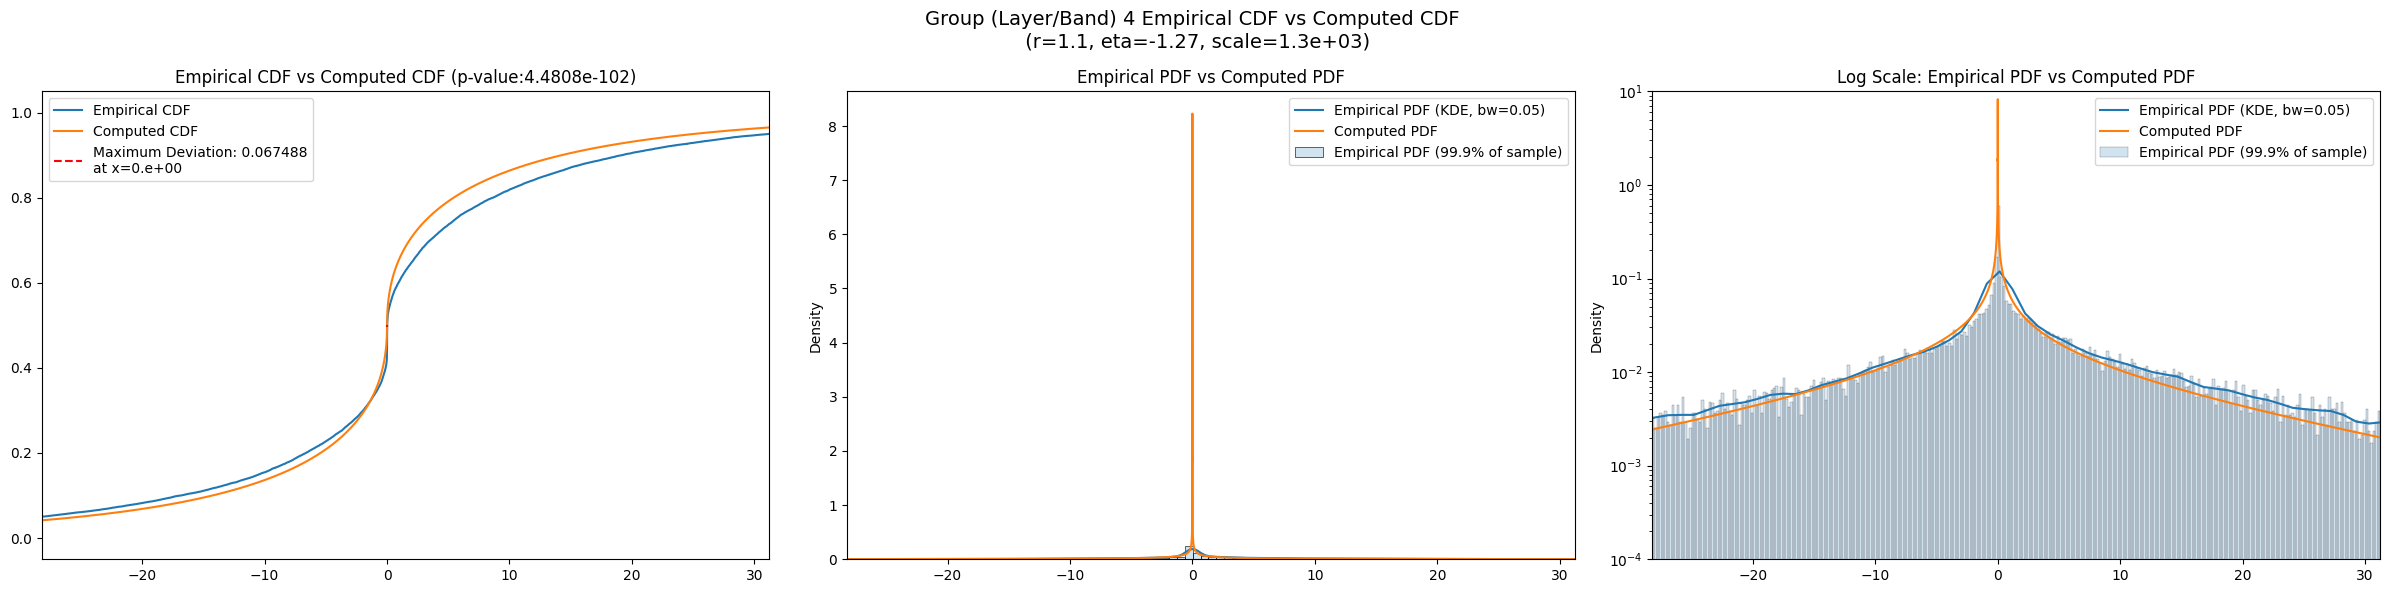

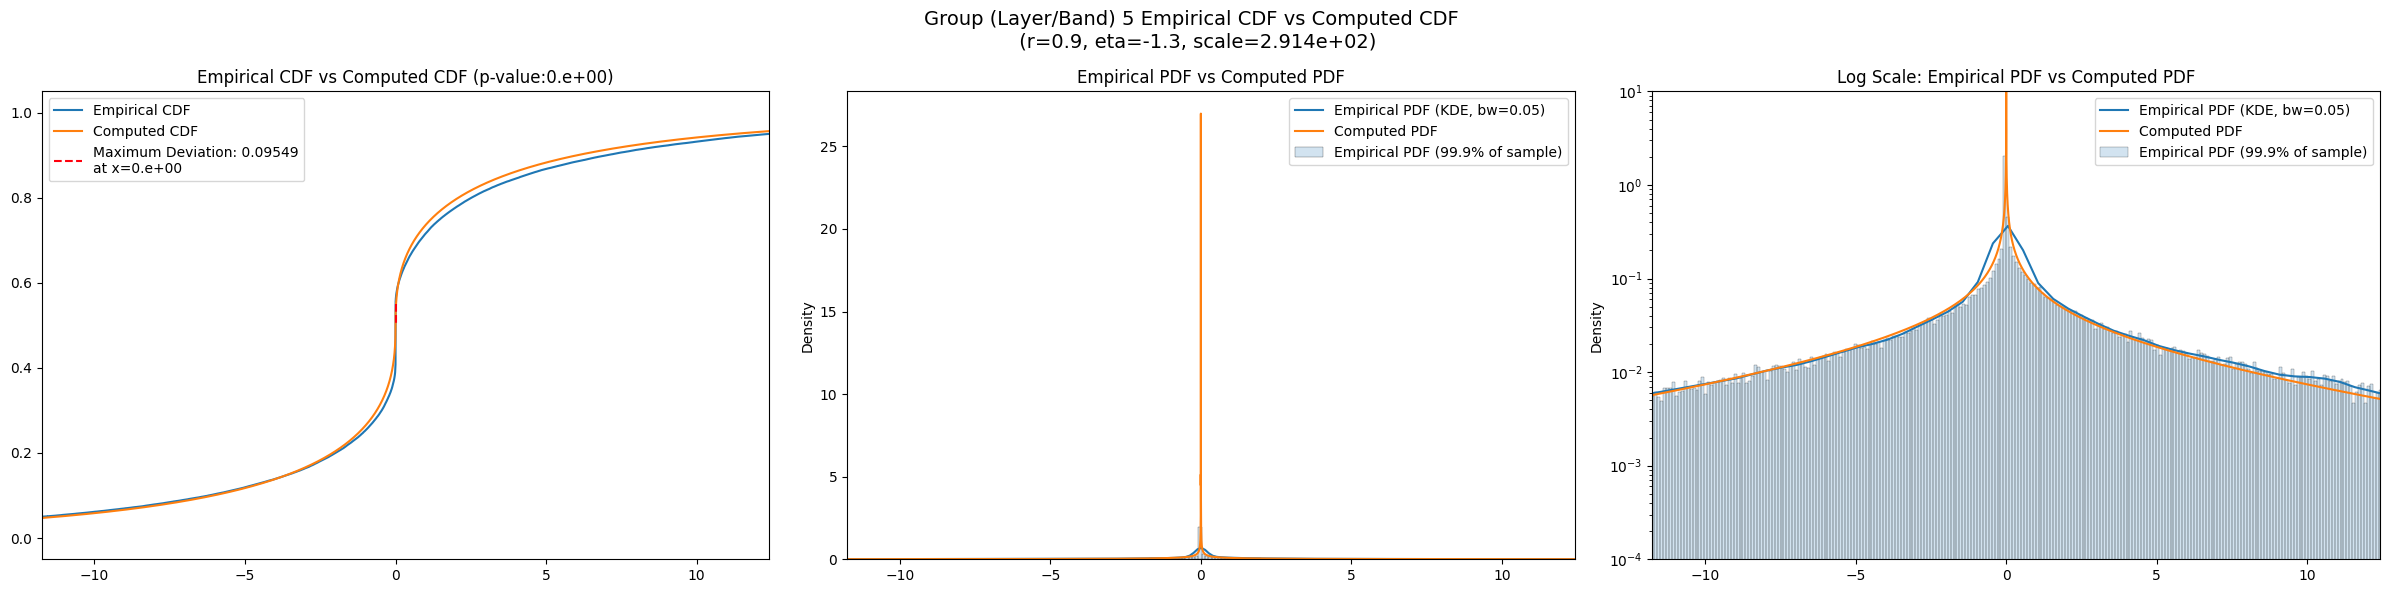

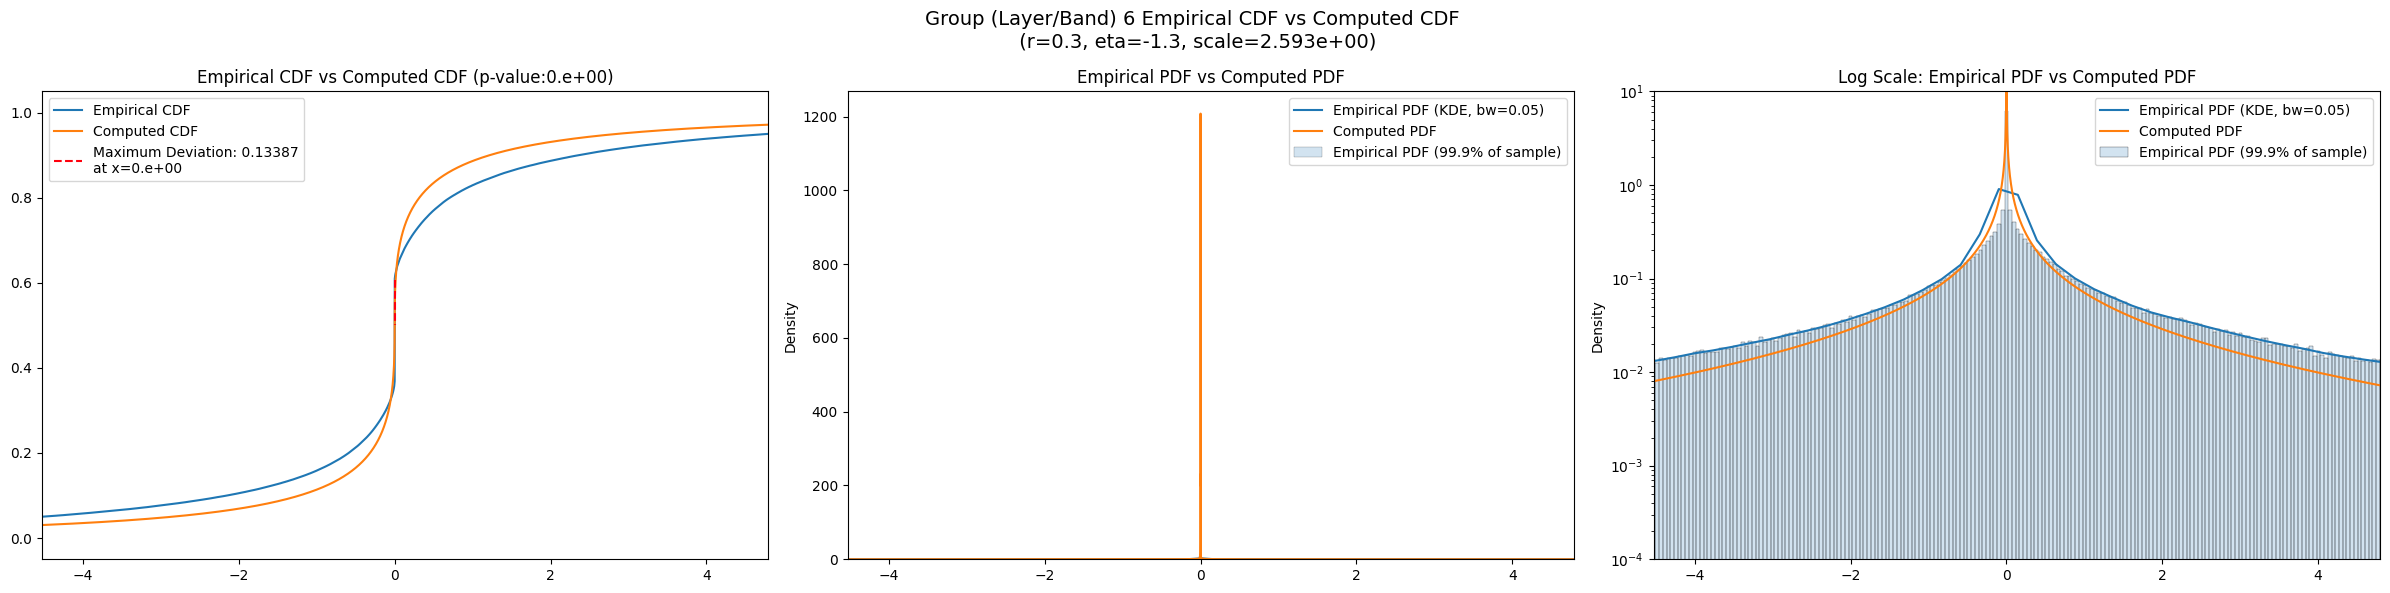

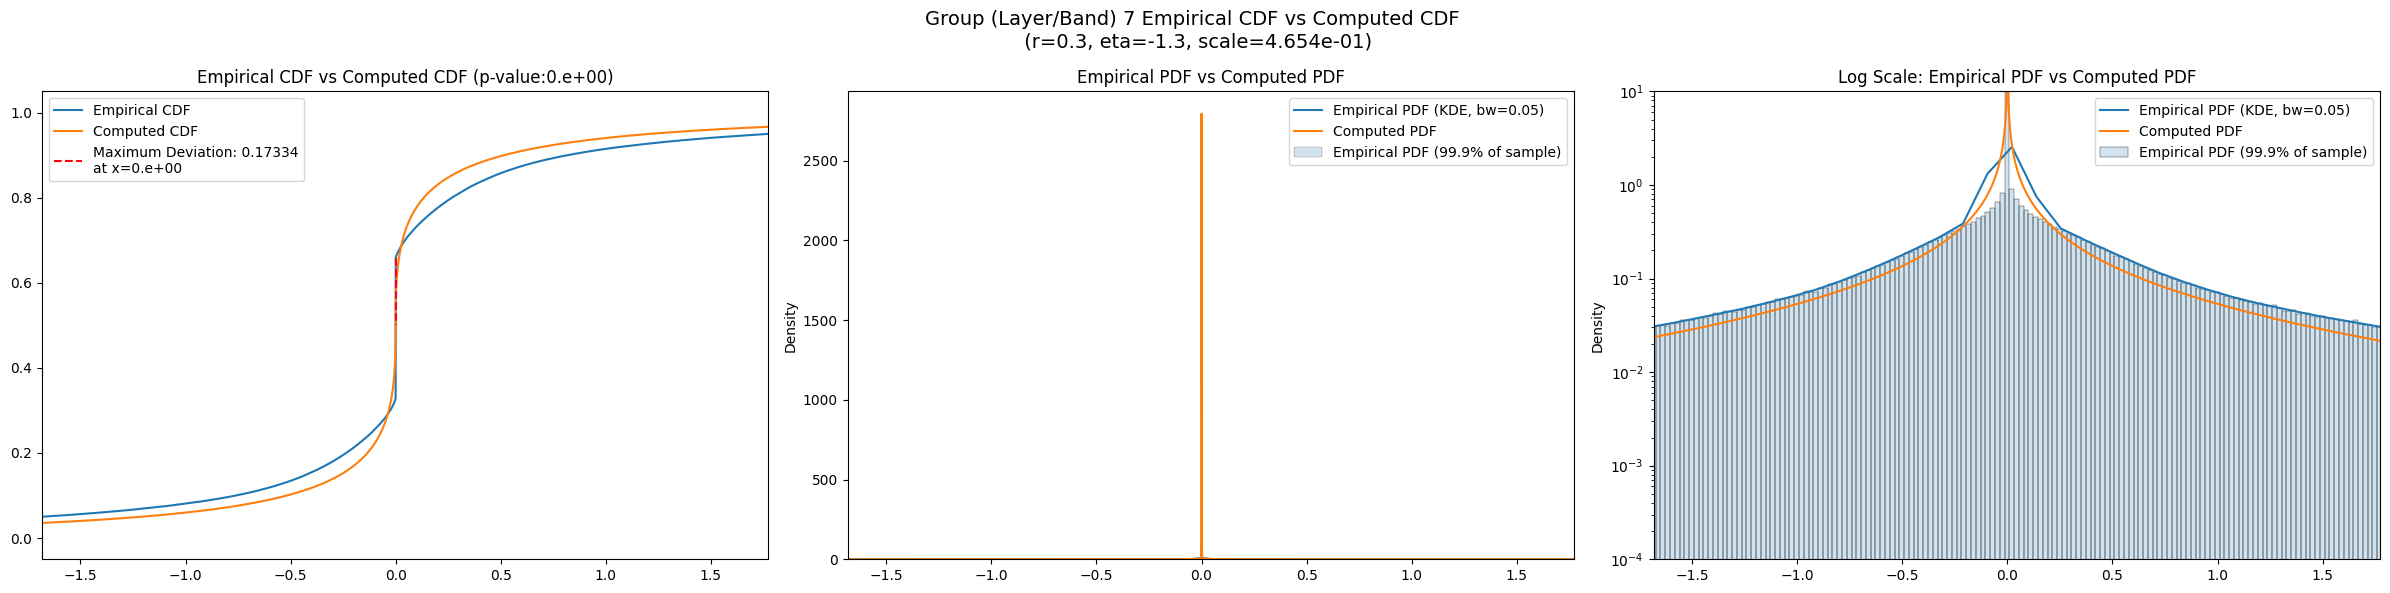

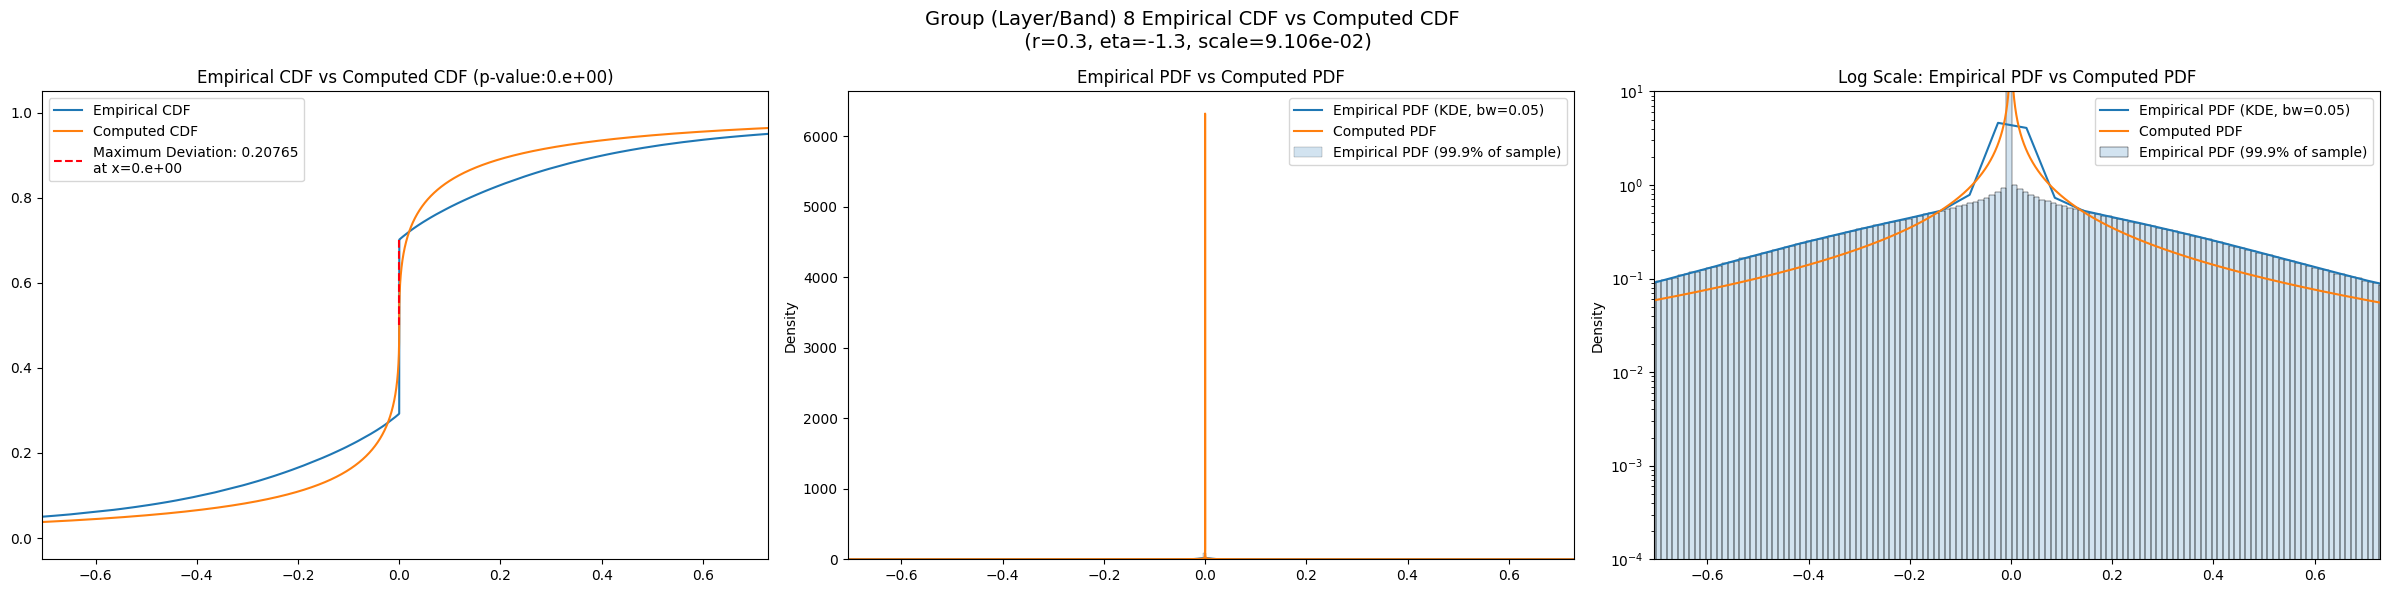

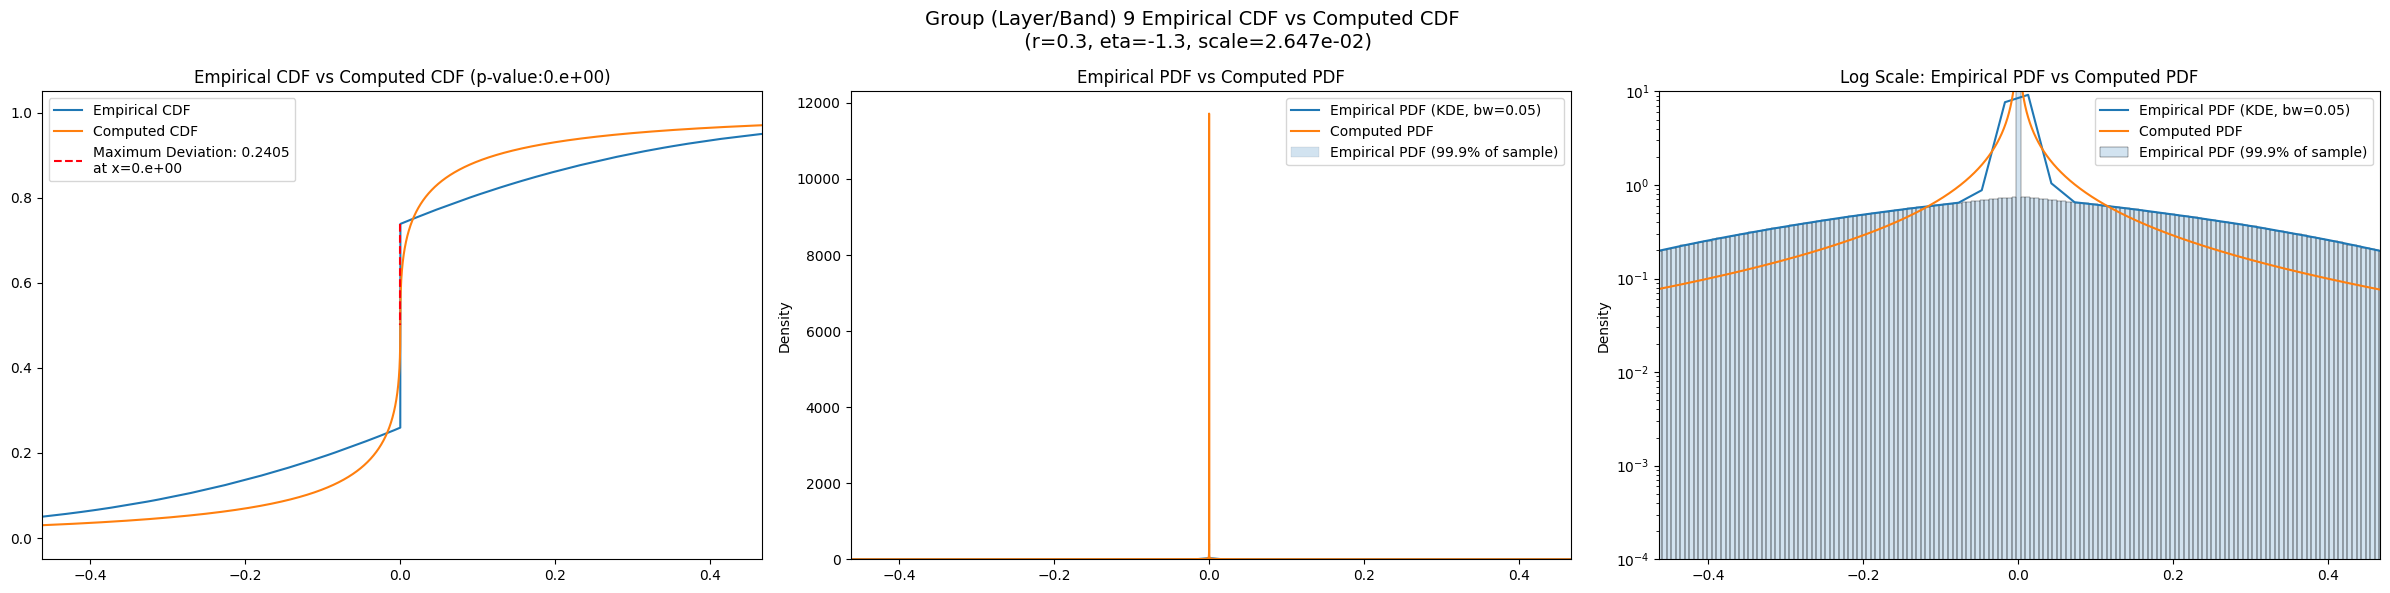

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      6587.218800  5829.085400  7390.837000   1.388779    0.753041   
3      1562.001600  1443.514600  1685.957800   3.834879    3.130261   
4       337.561950   313.361850   362.564180   5.918980    5.145904   
5        63.356410    58.123432    68.839920   8.944126    7.824841   
6        11.491563    10.353099    12.688133  13.758188   11.807414   
7         2.062334     1.823033     2.322947  19.980927   16.740900   
8         0.403471     0.351124     0.461097  25.597855   20.274683   
9         0.117287     0.103159     0.132794  22.309376   16.614643   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.140820           1604             0.086021        1.4         -0.8   
3        4.593748           6416             0.068584        1.1         -1.1   
4        6.765697          25664             0.067488        1.5         -1.3   
5       10.135998         102656             0.095490        0.9         -1.3   
6       15.933593         410624             0.133870        0.3         -1.3   
7       23.600847        1642496             0.173340        0.3         -1.3   
8       31.850876        6569984             0.207650        0.3         -1.3   
9       28.714006       26279936             0.240500        0.3         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       60.793500              0.093887          9.344040e-13   
3      ...       21.427100              0.100085          2.116050e-56   
4      ...        7.449390              0.109394         6.230760e-268   
5      ...        2.136610              0.126187          0.000000e+00   
6      ...        0.550904              0.141136          0.000000e+00   
7      ...        0.141591              0.173346          0.000000e+00   
8      ...        0.189546              0.207650          0.000000e+00   
9      ...        0.078422              0.240500          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          52.868500             0.088181         2.658420e-11  45.007900   
3          17.922500             0.086844         1.500650e-42  15.096800   
4           5.833440             0.094927        9.951830e-202   4.707300   
5           1.616220             0.113457         0.000000e+00   1.246190   
6           0.382602             0.135083         0.000000e+00   0.289087   
7           0.091997             0.173342         0.000000e+00   0.069426   
8           0.205307             0.207650         0.000000e+00   0.186053   
9           0.126888             0.240500         0.000000e+00   0.078422   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.090030   9.193620e-12          9.559804e-11  
3           0.091270   5.839240e-47          1.143199e-25  
4           0.098301  2.541150e-216         4.480806e-102  
5           0.114879   0.000000e+00          0.000000e+00  
6           0.135538   0.000000e+00          0.000000e+00  
7           0.173343   0.000000e+00          0.000000e+00  
8           0.207650   0.000000e+00          0.000000e+00  
9           0.240500   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.086021                 0.033804          0.085899   
3                 0.068584                 0.016929          0.067244   
4                 0.067488                 0.008471          0.067488   
5                 0.095490                 0.004237          0.095490   
6                 0.133870                 0.002119          0.133870   
7                 0.173340                 0.001060          0.173340   
8                 0.207650                 0.000530          0.207650   
9                 0.240500                 0.000265          0.240500   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.093887             0.088181       0.090030  
3                  0.100085             0.086844       0.091270  
4                  0.109394             0.094927       0.098301  
5                  0.126187             0.113457       0.114879  
6                  0.141136             0.135083       0.135538  
7                  0.173346             0.173342       0.173343  
8                  0.207650             0.207650       0.207650  
9                  0.240500             0.240500       0.240500

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             6587.218750          0.085899     1.8     -0.83  15025.522582   
3             1562.001587          0.067244     1.5     -1.14   5560.907151   
4              280.207733          0.067488     1.1     -1.27   1299.727434   
5               63.356410          0.095490     0.9     -1.30    291.359588   
6               11.491563          0.133870     0.3     -1.30      2.593489   
7                2.062334          0.173340     0.3     -1.30      0.465441   
8                0.403471          0.207650     0.3     -1.30      0.091058   
9                0.117287          0.240500     0.3     -1.30      0.026470   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                    100.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()